# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


1. 필요한 라이브러리 설치 및 환경 설정


In [1]:
# # timm 라이브러리 설치
# !pip install timm

2. 라이브러리 불러오기


In [2]:
# 필요한 라이브러리 임포트
import os
import time
import random
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import optuna
import torch.cuda.amp

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# 현재 사용 중인 GPU와 관련된 정보를 출력
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  사용 가능한 메모리: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  현재 사용 중인 메모리: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"  현재 캐시된 메모리: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
else:
    print("CUDA 사용 불가. GPU가 없습니다.")

GPU 0: NVIDIA GeForce RTX 3090
  사용 가능한 메모리: 25.44 GB
  현재 사용 중인 메모리: 0.00 GB
  현재 캐시된 메모리: 0.00 GB


3. 시드 고정


In [4]:
# 시드 고정
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything()

4. 데이터 경로 설정 및 CSV 파일 로드


In [5]:
# 데이터 경로 및 증강 파라미터 설정
original_csv = "data/train.csv"
original_path = "data/train/"
augmented_path = "data/augmented_train_06/"
os.makedirs(augmented_path, exist_ok=True)
df = pd.read_csv(original_csv)
augment_factor = 80  # 각 이미지를 80배 증강

5. 데이터 증강 설정


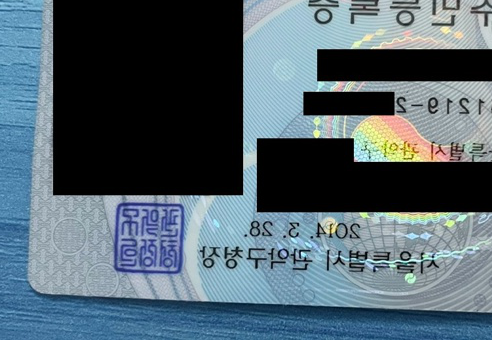

In [55]:
# 어그멘테이션 매개변수 정의
rotations = [15, 30, 45, 60, 75, 90, 180, 270, 360]  # 회전 각도
flips = [True, False]                                # 좌우반전
noises = [True, False]                               # 가우시안 노이즈 적용 여부
corners = ['top-left', 'top-right', 'bottom-left', 'bottom-right']  # 모서리 크롭 위치

def add_gaussian_noise(image, mean=0, std=25):
    """가우시안 노이즈 추가"""
    image_array = np.array(image)
    noise = np.random.normal(mean, std, image_array.shape).astype(np.uint8)
    noisy_image = np.clip(image_array + noise, 0, 255)
    return Image.fromarray(noisy_image.astype(np.uint8))

def augment_image(image):
    """주어진 이미지에 다양한 어그멘테이션 적용"""
    # 회전
    rotation_angle = random.choice(rotations)
    image = image.rotate(rotation_angle, expand=True)  # expand=True로 크기 조정

    # 좌우 반전
    if random.choice(flips):
        image = ImageOps.mirror(image)

    # 가우시안 노이즈 추가
    if random.choice(noises):
        image = add_gaussian_noise(image)

    # 모서리 크롭 (80% 유지)
    width, height = image.size
    crop_width = int(width * 0.8)
    crop_height = int(height * 0.8)
    corner_position = random.choice(corners)

    if corner_position == 'top-left':
        image = image.crop((0, 0, crop_width, crop_height))
    elif corner_position == 'top-right':
        image = image.crop((width - crop_width, 0, width, crop_height))
    elif corner_position == 'bottom-left':
        image = image.crop((0, height - crop_height, crop_width, height))
    else:  # 'bottom-right'
        image = image.crop((width - crop_width, height - crop_height, width, height))

    return image

# 사용 예시
if __name__ == "__main__":
    image_path = os.path.join(original_path, '0a1b8d3c52d64052.jpg')
    image = Image.open(image_path)
    augmented_image = augment_image(image)
    augmented_image.show()  # 결과 출력


6. 증강된 이미지 생성 및 저장


In [ ]:
# # 증강된 이미지 생성 및 저장
# augmented_data = []
# for i, (img_name, target) in enumerate(tqdm(df.values, desc="Generating augmented images")):
#     img_path = os.path.join(original_path, img_name)
#     image = Image.open(img_path).convert("RGB")
#     for j in range(augment_factor):
#         augmented_img = augment_image(image)
#         save_name = f"{os.path.splitext(img_name)[0]}_aug_{j}.jpg"
#         save_path = os.path.join(augmented_path, save_name)
#         augmented_img.save(save_path, quality=95)  # 이미지 품질 설정
#         augmented_data.append([save_name, target])

7. 증강된 데이터 CSV 파일 생성


In [ ]:
# # 증강된 데이터 CSV 파일 생성
# augmented_df = pd.DataFrame(augmented_data, columns=['image_name', 'label'])
# augmented_df.to_csv("data/augmented_train_06.csv", index=False)

8. 데이터셋 클래스 정의


In [9]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = Image.open(os.path.join(self.path, name)).convert("RGB")
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target


9. 학습 및 테스트 데이터 증강 설정


In [10]:
# 학습 데이터 증강 설정
trn_transform = A.Compose([
    A.Resize(height=380, width=380),
    A.Rotate(limit=20, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
    A.GaussNoise(var_limit=(10.0, 70.0), p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.3),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    ], p=0.3),
    A.CoarseDropout(max_holes=8, max_height=12, max_width=12, min_holes=1, min_height=4, min_width=4, fill_value=0, p=0.3),
    A.ElasticTransform(alpha=1, sigma=60, alpha_affine=60, p=0.3),
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
        A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),
    ], p=0.3),
    A.Flip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# 테스트 데이터 증강 설정
tst_transform = A.Compose([
    A.Resize(height=380, width=380),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


13. 학습 함수 정의

In [11]:
# 학습 함수 정의 (Mixed Precision 적용)
def train_one_epoch(loader, model, optimizer, loss_fn, device, scaler):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    pbar = tqdm(loader)

    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training을 위한 with autocast
        with torch.cuda.amp.autocast():
            preds = model(image)
            loss = loss_fn(preds, targets)

        # Scaler를 이용해 backward 및 optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())
        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')
    return {"train_loss": train_loss, "train_acc": train_acc, "train_f1": train_f1}


10. 하이퍼파라미터 설정


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# 하이퍼파라미터 최적화 함수 정의
def objective(trial):
    # 하이퍼파라미터 최적화 범위 설정
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8])
    num_workers = trial.suggest_int('num_workers', 2, 8)
    epochs = trial.suggest_int('epochs', 2, 10)

    # 하이퍼파라미터에 맞춰 데이터 로더 설정
    train_dataset = ImageDataset("data/augmented_train_06.csv", augmented_path, transform=trn_transform)
    model = timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=17).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()

    while batch_size >= 4:
        try:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            metrics = train_one_epoch(train_loader, model, optimizer, loss_fn, device, scaler)
            train_loss = metrics['train_loss']
            return train_loss
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                batch_size //= 2
                torch.cuda.empty_cache()
            else:
                raise

# Optuna로 하이퍼파라미터 최적화 수행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.params)

# 최적화된 하이퍼파라미터로 모델 재설정
best_params = study.best_trial.params
batch_size = best_params['batch_size']
lr = best_params['lr']
num_workers = best_params['num_workers']
EPOCHS = best_params['epochs']


[I 2024-11-05 08:24:51,640] A new study created in memory with name: no-name-ee26c0fd-282e-4430-816f-6261e81f3ffd
Loss: 0.0028: 100%|██████████| 15700/15700 [33:30<00:00,  7.81it/s]
[I 2024-11-05 08:58:23,479] Trial 0 finished with value: 0.17093420993940087 and parameters: {'lr': 3.457879656296629e-05, 'batch_size': 8, 'num_workers': 3, 'epochs': 5}. Best is trial 0 with value: 0.17093420993940087.
Loss: 0.0000: 100%|██████████| 15700/15700 [31:57<00:00,  8.19it/s]
[I 2024-11-05 09:30:22,473] Trial 1 finished with value: 0.15621851801967165 and parameters: {'lr': 0.00013209795211121823, 'batch_size': 8, 'num_workers': 4, 'epochs': 8}. Best is trial 1 with value: 0.15621851801967165.
Loss: 0.0014: 100%|██████████| 15700/15700 [31:56<00:00,  8.19it/s]
[I 2024-11-05 10:02:20,044] Trial 2 finished with value: 0.18848268145778377 and parameters: {'lr': 2.683692604476184e-05, 'batch_size': 8, 'num_workers': 5, 'epochs': 8}. Best is trial 1 with value: 0.15621851801967165.
Loss: 0.0004: 100%

Best trial: {'lr': 7.861033802667968e-05, 'batch_size': 8, 'num_workers': 3, 'epochs': 6}


In [13]:
# 현재 사용 중인 GPU와 관련된 정보를 출력
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  사용 가능한 메모리: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  현재 사용 중인 메모리: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"  현재 캐시된 메모리: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
else:
    print("CUDA 사용 불가. GPU가 없습니다.")

GPU 0: NVIDIA GeForce RTX 3090
  사용 가능한 메모리: 25.44 GB
  현재 사용 중인 메모리: 0.02 GB
  현재 캐시된 메모리: 7.63 GB


11. DataLoader 정의


In [14]:
# 데이터셋 및 DataLoader 정의
train_dataset = ImageDataset("data/augmented_train_06.csv", augmented_path, transform=trn_transform)
tst_dataset = ImageDataset("data/sample_submission.csv", "data/test/", transform=tst_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [18]:
# 현재 사용 중인 GPU와 관련된 정보를 출력
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  사용 가능한 메모리: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  현재 사용 중인 메모리: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"  현재 캐시된 메모리: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
else:
    print("CUDA 사용 불가. GPU가 없습니다.")

GPU 0: NVIDIA GeForce RTX 3090
  사용 가능한 메모리: 25.44 GB
  현재 사용 중인 메모리: 0.02 GB
  현재 캐시된 메모리: 0.13 GB


In [17]:
# GPU 캐시된 메모리 삭제
torch.cuda.empty_cache()

print("캐시된 메모리가 삭제되었습니다.")

캐시된 메모리가 삭제되었습니다.


12. 모델 및 Optimizer 설정

In [19]:
# 모델 및 Optimizer 설정
model_name = 'tf_efficientnet_b7'
model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# GradScaler 정의 (Mixed Precision 학습을 위한)
scaler = torch.cuda.amp.GradScaler()

# 최적의 배치 사이즈와 워커 수로 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 학습 루프
for epoch in range(EPOCHS):
    train_metrics = train_one_epoch(train_loader, model, optimizer, loss_fn, device, scaler)
    print(f"Epoch {epoch+1}, Train Loss: {train_metrics['train_loss']:.4f}, "
          f"Train Acc: {train_metrics['train_acc']:.4f}, Train F1: {train_metrics['train_f1']:.4f}")


Loss: 0.0000: 100%|██████████| 15700/15700 [33:36<00:00,  7.79it/s]


Epoch 1, Train Loss: 0.1468, Train Acc: 0.9513, Train F1: 0.9487


Loss: 0.0003: 100%|██████████| 15700/15700 [33:39<00:00,  7.78it/s]


Epoch 2, Train Loss: 0.0347, Train Acc: 0.9888, Train F1: 0.9882


Loss: 0.0003: 100%|██████████| 15700/15700 [33:26<00:00,  7.82it/s]


Epoch 3, Train Loss: 0.0235, Train Acc: 0.9926, Train F1: 0.9922


Loss: 0.0000: 100%|██████████| 15700/15700 [33:31<00:00,  7.80it/s]


Epoch 4, Train Loss: 0.0192, Train Acc: 0.9939, Train F1: 0.9937


Loss: 0.0063: 100%|██████████| 15700/15700 [33:26<00:00,  7.82it/s]


Epoch 5, Train Loss: 0.0157, Train Acc: 0.9951, Train F1: 0.9948


Loss: 0.0000: 100%|██████████| 15700/15700 [33:36<00:00,  7.78it/s]


Epoch 6, Train Loss: 0.0144, Train Acc: 0.9954, Train F1: 0.9951


In [20]:
# 현재 사용 중인 GPU와 관련된 정보를 출력
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  사용 가능한 메모리: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  현재 사용 중인 메모리: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"  현재 캐시된 메모리: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
else:
    print("CUDA 사용 불가. GPU가 없습니다.")

GPU 0: NVIDIA GeForce RTX 3090
  사용 가능한 메모리: 25.44 GB
  현재 사용 중인 메모리: 1.06 GB
  현재 캐시된 메모리: 7.68 GB


15. 테스트 데이터 추론 및 결과 저장


In [21]:
# 테스트 데이터 추론 및 결과 저장
preds_list = []
model.eval()
for image, _ in tqdm(tst_loader, desc="Predicting test data"):
    image = image.to(device)
    with torch.no_grad():
        preds = model(image)
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

Predicting test data: 100%|██████████| 393/393 [00:24<00:00, 16.34it/s]


In [22]:
# 예측 결과 저장
submission = pd.read_csv("data/sample_submission.csv")
submission['target'] = preds_list
submission.to_csv("sebi_08.csv", index=False)

In [23]:
submission.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
